# Data visualization with seaborn
### Statistical data visualization

Last week we used pandas and matplotlib to make some basic graphs.  This time we will start to explore the data statistically, and use seaborn for statistical data visualization.  The point is to explore the relationships in the data.  This exercise is based on the seaborn tutorial.  For reference: 

http://seaborn.pydata.org/index.html

We won't cover them here, but if you get into this stuff you might check out: 

bokeh: does interactive data viz, much like we did interactive mapping earlier. 

http://bokeh.pydata.org/en/latest/
    
d3: this is a javascript library that has been used to create some of the most beautiful visualizations I have ever seen. 

https://github.com/d3/d3/wiki/Gallery

## Install

    conda install seaborn


In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd
import geopandas as gp
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

## Load the data sets

In this exercise, we are interested in understanding more about the congested roadway speed.  We may want to see what the speed distribution looks like, and how it relates to other variables.  We'll examine this today. 

In [2]:
# This file contains the street network of San Francisco.  
# Each link has a modeled traffic volume and travel time for the 5-6 pm period. 
net = gp.read_file('data/sf_links.shp')

# calculate the speed, in mph
net['Speed'] = net['Length'] / net['ModelTime5'] * 60

# see what we have
net.head()

,Direction,Length,LinkID,ANode,BNode,Label,Type,FacilityTy,FreeflowSp,NumLanes,ModelVolum,ModelTime5,geometry,Speed
0,EB,0.109211,3477.0,6956.0,40003.0,HWY 101 N OFF-RAMP to HARNEY WY,RoadLink,8.0,40.0,1.0,176.0,0.169666,LINESTRING (6013570.791748491 2085003.96208599...,38.620892
1,NB,0.151513,3478.0,6956.0,40029.0,HWY 101 NORTHBOUND,RoadLink,1.0,65.0,4.0,6247.0,0.172743,LINESTRING (6013590.440897825 2085010.56453974...,52.626085
2,SB,0.054407,3481.0,6985.0,6980.0,HWY 101 S ON-RAMP from BEATTY AVE,RoadLink,8.0,40.0,1.0,251.0,0.337117,LINESTRING (6013196.868106447 2085485.42769724...,9.683272
3,WB,0.279096,3482.0,6985.0,6986.0,BEATTY AVE,RoadLink,6.0,35.0,1.0,78.0,0.488893,LINESTRING (6013197.871166563 2085491.68336289...,34.252460
4,NB,0.103751,3483.0,6985.0,52492.0,ALANA WY,RoadLink,6.0,30.0,1.0,76.0,0.222079,"LINESTRING (6013204.215209286 2085486.3706171,...",28.030923


## Plotting univariate distributions

The most convenient way to take a quick look at a univariate distribution in seaborn is the distplot() function. By default, this will draw a histogram and fit a kernel density estimate (KDE).

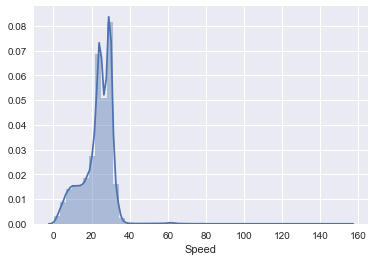

In [3]:
sns.distplot(net['Speed'])

If we want to control the limits of the x axes, we need to use the matplotlib commands like we did last week. 

(0, 50)

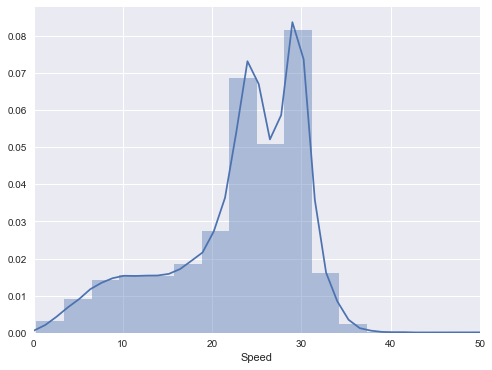

In [4]:
ax = sns.distplot(net['Speed'])
ax.figure.set_size_inches(8,6)
ax.set_xlim(0,50)

distplot() actually gives a combination of a histogram and a kernel density plot.  You can get just one or the other, and control the number of bins. 

Alternatively, you can also add a rug plot which gives a vertical tick for each observation. 

(0, 50)

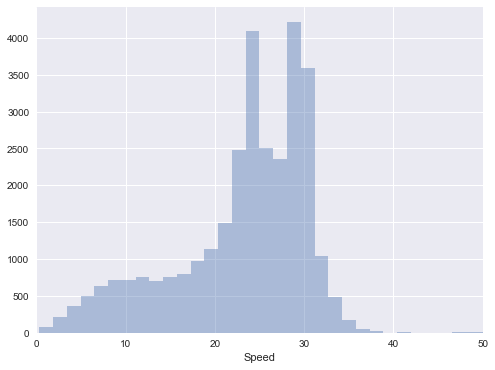

In [5]:
ax = sns.distplot(net['Speed'], kde=False, bins=100)
ax.figure.set_size_inches(8,6)
ax.set_xlim(0,50)

The kernel density estimate may be less familiar, but it can be a useful tool for plotting the shape of a distribution. Like the histogram, the KDE plots encodes the density of observations on one axis with height along the other axis. 

Drawing a KDE is more computationally involved than drawing a histogram. What happens is that each observation is first replaced with a normal (Gaussian) curve centered at that value.  

Next, these curves are summed to compute the value of the density at each point in the support grid. The resulting curve is then normalized so that the area under it is equal to 1. 

The bandwidth (bw) parameter of the KDE controls how tightly the estimation is fit to the data, much like the bin size in a histogram. It corresponds to the width of the kernels we plotted above. The default behavior tries to guess a good value using a common reference rule, but it may be helpful to try larger or smaller values. 

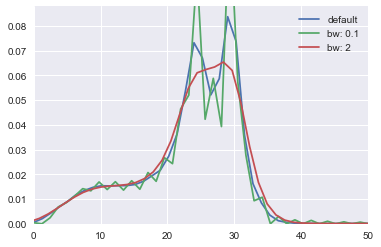

In [6]:
#smaller bandwith = more correlation
ax = sns.kdeplot(net['Speed'], label='default')
ax = sns.kdeplot(net['Speed'], bw=.1, label="bw: 0.1")
ax = sns.kdeplot(net['Speed'], bw=2, label="bw: 2")

ax.set_xlim(0,50)
plt.legend();

You can also use distplot() to fit a parametric distribution to a dataset and visually evaluate how closely it corresponds to the observed data:

(0, 50)

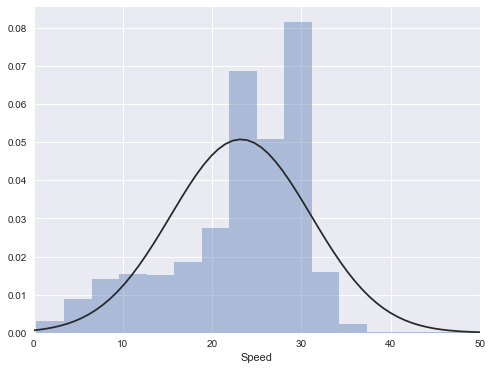

In [7]:
# here we try to fit a normal distribution
ax = sns.distplot(net['Speed'], kde=False, fit=stats.norm)
ax.figure.set_size_inches(8,6)
ax.set_xlim(0,50)

In the above case, the normal distribution doesn't fit very well.  This can be an issue because many statistical tests are based on an assumption that your data follows a particular distribution.  If it doesn't, the test may be invalid.  This is why it is important to actually visualize it.  

## Plotting bivariate distributions

It can also be useful to visualize a bivariate distribution of two variables. The easiest way to do this in seaborn is to just the jointplot() function, which creates a multi-panel figure that shows both the bivariate (or joint) relationship between two variables along with the univariate (or marginal) distribution of each on separate axes.

#### Scatterplots

The most familiar way to visualize a bivariate distribution is a scatterplot, where each observation is shown with point at the x and y values. This is analgous to a rug plot on two dimensions. You can draw a scatterplot with the matplotlib plt.scatter function, and it is also the default kind of plot shown by the jointplot() function:

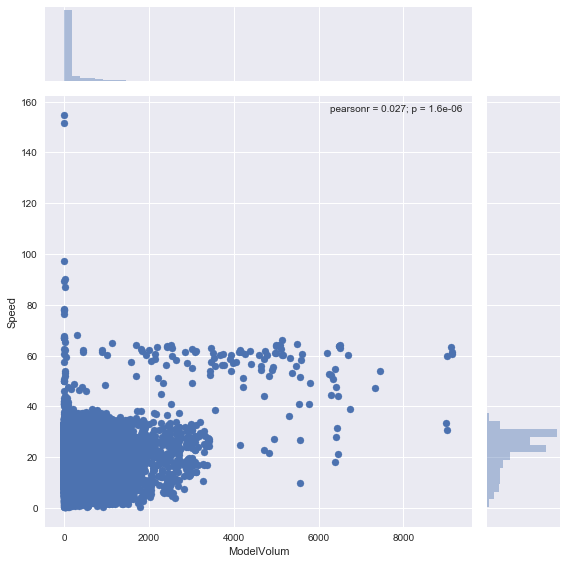

In [8]:
# plot the speed vs traffic volume
sns.jointplot(x="ModelVolum", y="Speed", data=net, size=8)

#### Hexbin plots

There are a lot of points in the bottom left, so its hard to see what is going on.  We can look at this a bit better using something called a hexbin plot. 

The bivariate analogue of a histogram is known as a “hexbin” plot, because it shows the counts of observations that fall within hexagonal bins. This plot works best with relatively large datasets. It’s availible through the matplotlib plt.hexbin function and as a style in jointplot(). It looks best with a white background:

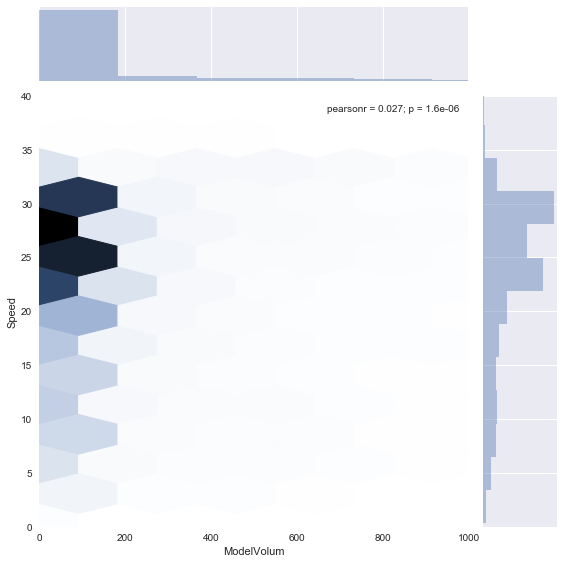

In [9]:
# plot the speed vs traffic volume
sns.jointplot(x="ModelVolum", 
              y="Speed", 
              data=net, 
              kind='hex', 
              size=8, 
              xlim=(0,1000), 
              ylim=(0,40))

#### Kernel density estimation

It is also posible to use the kernel density estimation procedure described above to visualize a bivariate distribution. In seaborn, this kind of plot is shown with a contour plot and is available as a style in jointplot():

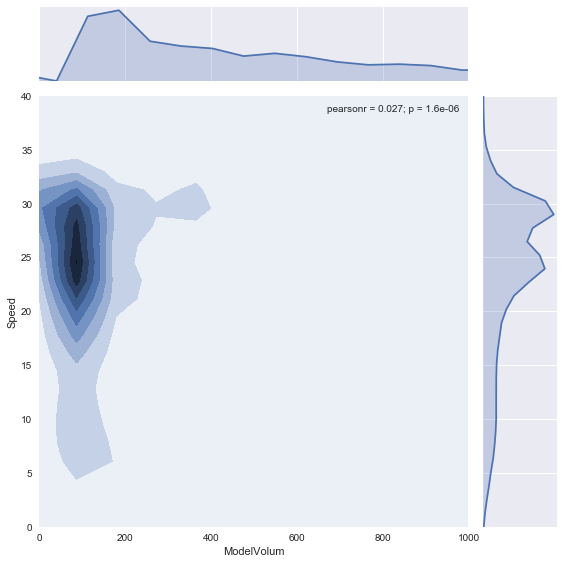

In [10]:
# plot the speed vs traffic volume
sns.jointplot(x="ModelVolum", 
              y="Speed", 
              data=net, 
              kind='kde', 
              size=8, 
              bw=2,
              xlim=(0,1000), 
              ylim=(0,40))

## Visualizing pairwise relationships in a dataset

To plot multiple pairwise bivariate distributions in a dataset, you can use the pairplot() function. This creates a matrix of axes and shows the relationship for each pair of columns in a DataFrame. by default, it also draws the univariate distribution of each variable on the diagonal Axes:

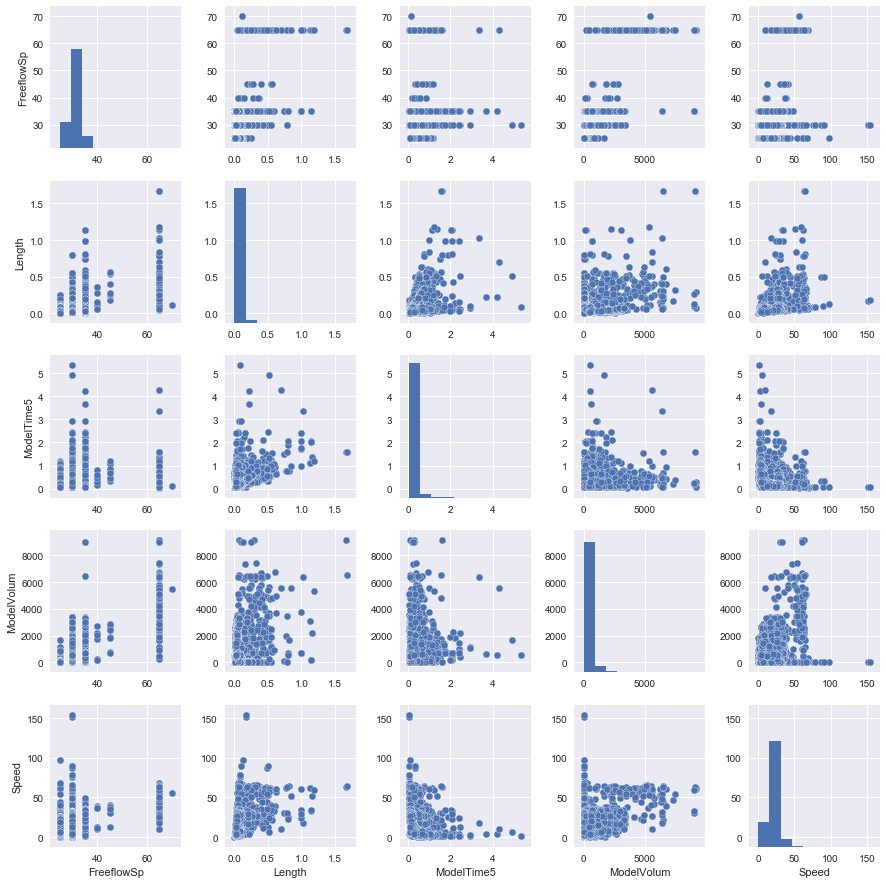

In [11]:
# only for selected columns
cols = ['FreeflowSp', 'Length', 'ModelTime5', 'ModelVolum', 'Speed']

# and teh plots
sns.pairplot(net[cols]) 

## Drawing linear regression models

We can easily draw a scatterplot and fit a linear regression model. 

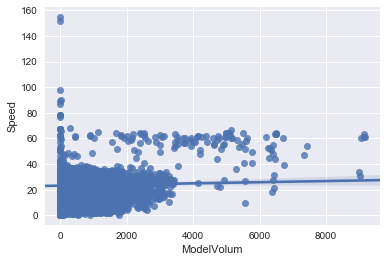

In [12]:
sns.regplot(x="ModelVolum", y="Speed", data=net);

Or we can make this different for freeways vs non-freeways. 

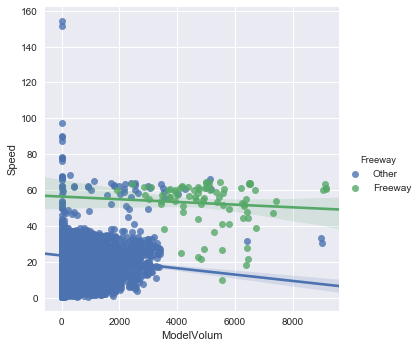

In [13]:
# freeways are facility type 1
net['Freeway'] = net['FacilityTy'].apply(lambda x : 'Freeway' if x==1 else 'Other')

sns.lmplot(x="ModelVolum", y="Speed", hue='Freeway', data=net);

## Exploring categories
We previously learned how to use scatterplots and regression model fits to visualize the relationship between two variables and how it changes across levels of additional categorical variables. However, what if one of the main variables you are interested in is categorical? In this case, the scatterplot and regression model approach won’t work. There are several options, however, for visualizing such a relationship, which we will discuss in this tutorial.

#### Categorical scatterplots

A simple way to show the the values of some quantitative variable across the levels of a categorical variable uses stripplot(), which generalizes a scatterplot to the case where one of the variables is categorical:

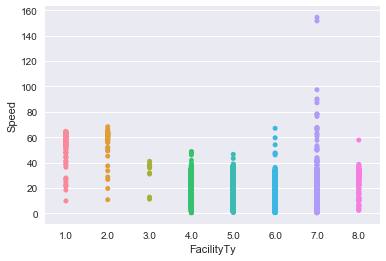

In [14]:
sns.stripplot(x="FacilityTy", y="Speed", data=net);

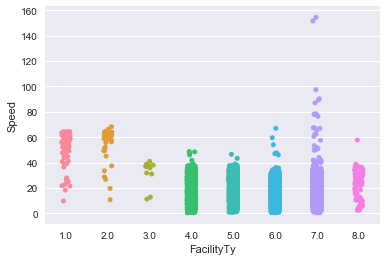

In [15]:
# this is hard to see, so let's add some 'jitter'

sns.stripplot(x="FacilityTy", y="Speed", data=net, jitter=True);

#### Boxplots

At a certain point, the categorical scatterplot approach becomes limited in the information it can provide about the distribution of values within each category. There are several ways to summarize this information in ways that facilitate easy comparisons across the category levels. These generalize some of the approaches we discussed in the chapter to the case where we want to quickly compare across several distributions.

The first is the familiar boxplot(). This kind of plot shows the three quartile values of the distribution along with extreme values. The “whiskers” extend to points that lie within 1.5 IQRs of the lower and upper quartile, and then observations that fall outside this range are displayed independently. Importantly, this means that each value in the boxplot corresponds to an actual observation in the data:

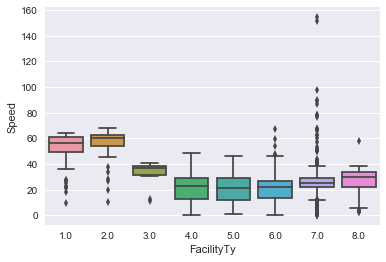

In [16]:
sns.boxplot(x="FacilityTy", y="Speed", data=net)

#### Violinplots

A different approach is a violinplot(), which combines a boxplot with the kernel density estimation procedure described in the distributions tutorial:

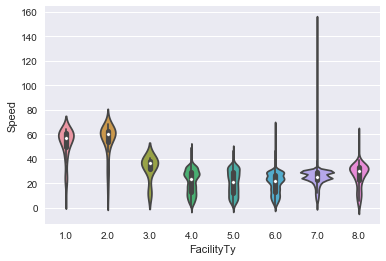

In [17]:
sns.violinplot(x="FacilityTy", y="Speed", data=net)

# Homework

Explore this data set and explain which factors most affect the link speed.  Use visualizations to support your case.  Your should first conduct an exploratory analysis, and then once you have figured out your story, clearly label a section with just the relevant explanation and supporting figures.  Make it easy for me to review just the 'bottom line'!

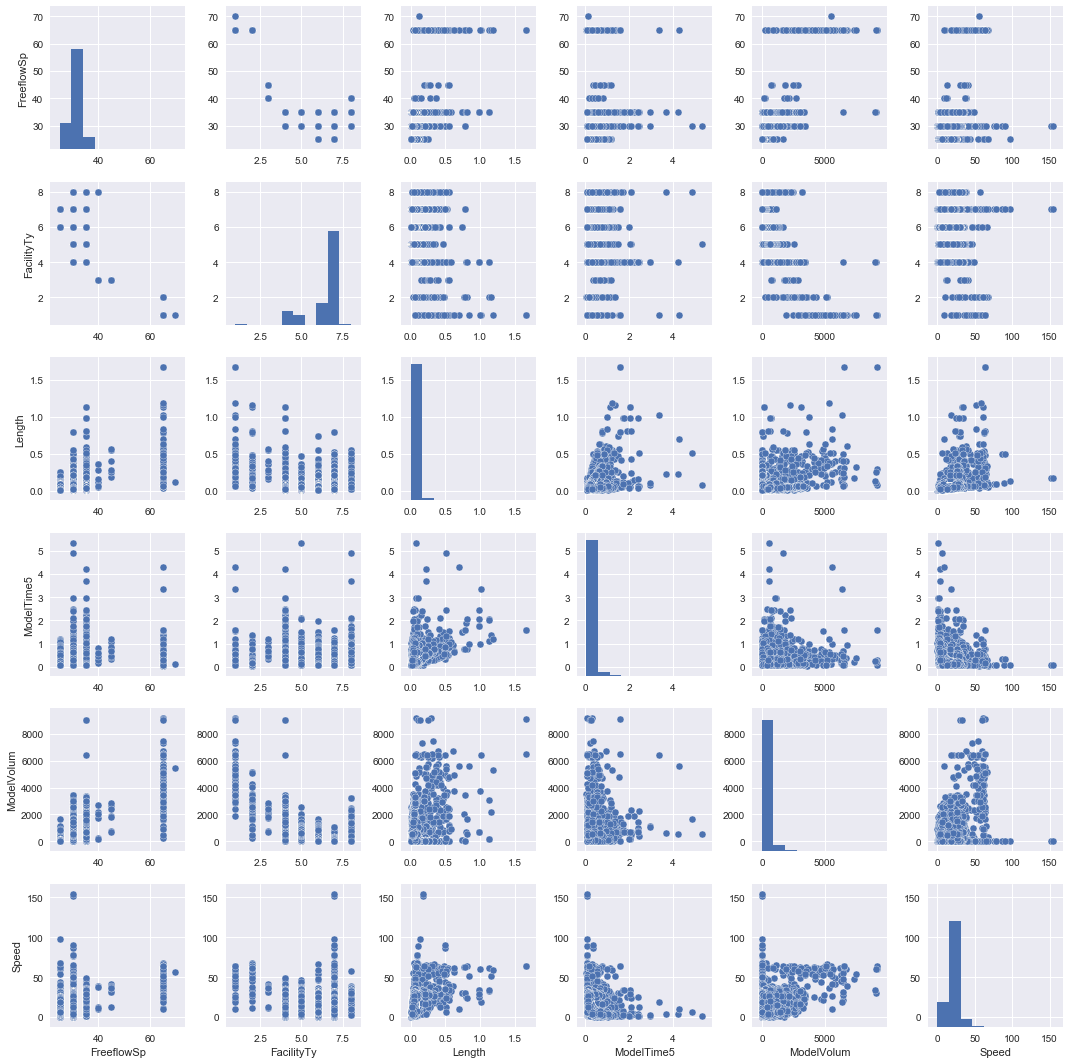

In [18]:
cols = ['FreeflowSp', 'FacilityTy', 'Length', 'ModelTime5', 'ModelVolum', 'Speed']

sns.pairplot(net[cols]) 

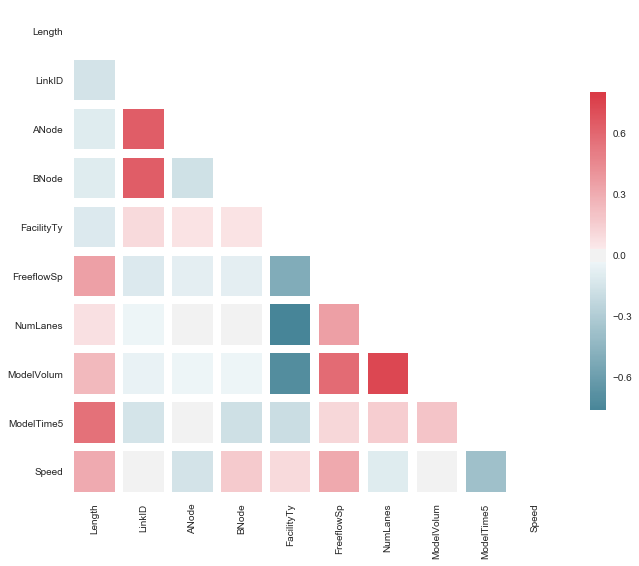

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "white")

#correlations
corr = net.corr()

#mask for upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

#setup matplotlib figure
f, ax = plt.subplots(figsize = (11,9))

#custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

#draw heatmap
hm = sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .8, center = 0, square = True, linewidths = 7.5, cbar_kws={"shrink": .65})

hm.figure.savefig("Correlation Heatmap.png")


In [20]:
#only find correlations for speed in the correlation dataframe
#also, delete last entry, which correlates speed with speed (1.0)
corr_onlyspeed = corr.Speed[:9]
corr_onlyspeed

Length        0.311192
LinkID        0.011527
ANode        -0.152685
BNode         0.168223
FacilityTy    0.104244
FreeflowSp    0.316852
NumLanes     -0.095270
ModelVolum    0.027246
ModelTime5   -0.374850
Name: Speed, dtype: float64

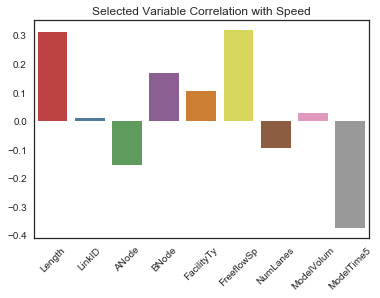

In [21]:
#create Seaborn barplot of speed correlation data
ax = sns.barplot(corr_onlyspeed.index, corr_onlyspeed.values, palette = sns.color_palette("Set1", n_colors=9, desat=.8))

#rotate x-axis labels
for item in ax.get_xticklabels():
    item.set_rotation(45)

#set a title
ax.set_title('Selected Variable Correlation with Speed')

#font size
#sns.set(font_scale=2.5)

#save graph
ax.figure.savefig("Speed Correlation Barplot.png")

Speed Correlations:

Length: .31

Freeflow Speed: .32

Model Time: -.37

As we can see in the correlation barplot above and by inspection of the corr_onlyspeed series, speed is correlated most positively correlated with freeflow speed and length of the node section.  Freeflow speed will obviously have a positive correlation with speed because they both have a component of speed to them.  Length is less intuitive.  As a car moves along a length of road, it will continue its acceleration, thus leading to higher speeds.

There is a semi-strong negative correlation with the model time.  This negative correlation is relatively intuitive.  As the speed increases, the time spent getting to the destination will decrease.

**However, let us not take this data out of context.  Much more rigorous statistical analysis must be performed before we can come to any conclusions.  We must do a multivariate analysis and test each variables individually to see which variables impact speed the most.  Even then, we can only come up with an equation which would model speed as a factor of these other variables.  We would be limited by pesky details such as human psychology, weather, wrecks, etc.